A Portuguese bank wants its clients to invest in term deposits, which are an investment such as a certificate of deposit. The interest rate and duration of the deposit are set in advance. A term deposit is distinct from a demand deposit. The bank is interested in identifying factors that affect client responses to new term deposit offerings, which are the focus of the marketing campaigns. Regarding the management problem, imagine that you are advising the bank about machine learning methods to guide telephone marketing campaigns. Which of the two modeling methods would you recommend and why? And, given the results of your research, which group of banking clients appears to be the best target for direct marketing efforts (similar to those used with previous telephone campaigns)? 

Use three binary explanatory variables relating to client banking history: default, housing, and loan. Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance. Python scikit-learn should be your primary environment for conducting this research.

**Summay of data**<br>

Categorical Variables:

- job : admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student
- marital : married, single, divorced
- education: secondary, tertiary, primary, unknown
- default : yes, no
- housing : yes, no
- loan : yes, no
- response : yes, no (target feature)
- contact : unknown, cellular, telephone
- month : jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
- poutcome: unknown, other, failure, success

Numerical Variables:

- age
- balance
- day
- duration
- campaign
- pdays
- previous

In [4]:
# Import dependencies 

# Data preparation and analysis
import numpy as np
import pandas as pd
import os
from math import sqrt  # for root mean-squared error calculation
import itertools
from scipy import stats as st
import random

# Modeling routines from Scikit Learn packages
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, classification_report, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.base import clone
import sklearn.utils.validation as val
from sklearn.utils import resample
from sklearn import preprocessing  # feature transformations 
from sklearn.compose import ColumnTransformer   # for scaling particular features
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit, train_test_split, cross_val_score, cross_val_predict, GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

# Plotting and visualization
from yellowbrick.model_selection import CVScores
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# Data preparation and initial inspection

In [6]:
# Initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')  # start with smaller data set

# Examine the shape of original input data
print(bank.shape)

(4521, 17)


In [7]:
# Drop observations with missing data, if any
bank.dropna()

# Examine the shape of input data after dropping missing data
print(bank.shape)

# Examine at the list of column names, note that y is the response
list(bank.columns.values)

# Examine the beginning of the DataFrame
bank.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


**Predictor variables relating to client banking history:**
- Default: Has credit in default? (yes/no) 
- Housing: Has housing loan? (yes/no)
- Loan: Has personal loan? (yes/no)

**Target variable:**
- Response: Has the client subscribed to a term deposit? (yes/no)

In [8]:
# Transform data
bank1 = pd.read_csv('bank.csv', sep = ';')

print([[bank1.columns],[bank1.dtypes]])
print(pd.DataFrame.head(bank1))

bank = pd.get_dummies(bank1)
print([[bank.columns],[bank.dtypes]])

[[Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'response'],
      dtype='object')], [age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
response     object
dtype: object]]
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        

# Descriptive statistics and exploratory data analysis
- crosstabs and descriptive statistics
- demographics of participants
- class balance across all categorical variables, especially response variable skew
- distributions of all features
- pair plots and correlation matrix 

In [9]:
# Crosstabs for initial analysis
a = pd.crosstab(bank.response_yes,
                bank.housing_yes,
                rownames=['Response'], colnames=['Housing'])
                
b = pd.crosstab(bank.response_yes,
                bank.loan_yes,
                rownames=['Response'], colnames=['Loan'])
                
c = pd.crosstab(bank.response_yes,
                bank.default_yes,
                rownames=['Response'], colnames=['Default'])

print(a,"\n")
print(b,"\n")
print(c,"\n")
        
def myor(a):
        myv=round((a.loc[1,1]/a.loc[0,1])/(a.loc[1,0]/a.loc[0,0]),3)
        logmyv = np.log(myv)
        se = np.sqrt(1/(a.loc[1,1]+1/a.loc[0,1]+a.loc[1,0]+a.loc[0,0]))
        lower = round(np.exp(logmyv-1.96*se),3)
        upper = round(np.exp(logmyv+1.96*se),3)
        return [myv, lower, upper]
                
print("Odds for Response Yes for Each Variable with 95% CI")
print("If housing = yes, odds for response = yes:", myor(a))
print("If loan = yes, odds for response = yes:", myor(b))
print("If default = yes, odds for response = yes:", myor(c))    
                
print(bank1.groupby('response').mean())

Housing      0     1
Response            
0         1661  2339
1          301   220 

Loan         0    1
Response           
0         3352  648
1          478   43 

Default      0   1
Response          
0         3933  67
1          512   9 

Odds for Response Yes for Each Variable with 95% CI
If housing = yes, odds for response = yes: [0.519, 0.498, 0.541]
If loan = yes, odds for response = yes: [0.465, 0.451, 0.48]
If default = yes, odds for response = yes: [1.032, 1.002, 1.063]
                age      balance        day    duration  campaign      pdays  \
response                                                                       
no        40.998000  1403.211750  15.948750  226.347500  2.862250  36.006000   
yes       42.491363  1571.955854  15.658349  552.742802  2.266795  68.639155   

          previous  
response            
no        0.471250  
yes       1.090211  


In [10]:
# Define binary variable for yes/no responses and map to original DataFrame columns
bank1['default'] = bank1['default'].map({'yes': 1, 'no': 0})
bank1['housing'] = bank1['housing'].map({'yes': 1, 'no': 0})
bank1['loan'] = bank1['loan'].map({'yes': 1, 'no': 0})
bank1['response'] = bank1['response'].map({'yes': 1, 'no': 0})

In [11]:
bank1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


In [12]:
bank1.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,response
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,0.016810,1422.657819,0.566025,0.152842,15.915284,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,0.128575,3009.638142,0.495676,0.359875,8.247667,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,0.000000,-3313.000000,0.000000,0.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,69.000000,0.000000,0.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,444.000000,1.000000,0.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,0.000000,1480.000000,1.000000,0.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,1.000000,71188.000000,1.000000,1.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


**Figure 1: Feature Distributions**

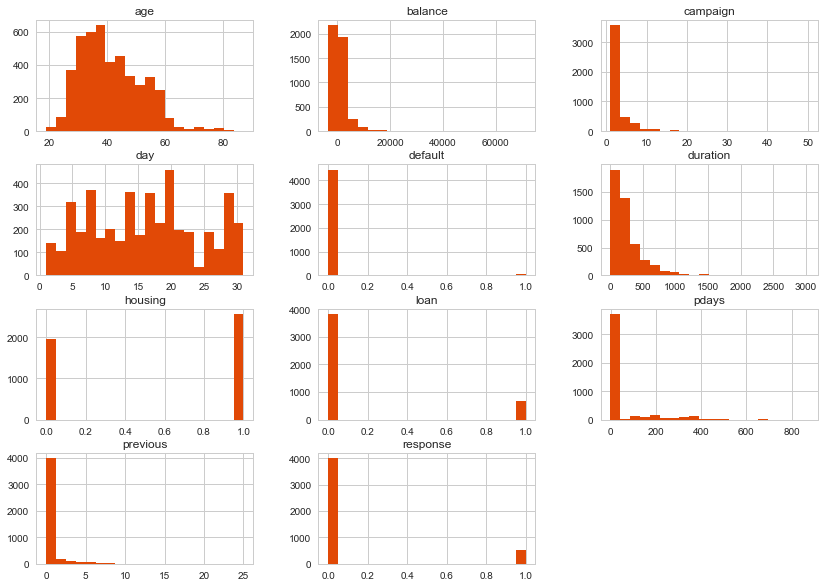

In [15]:
# Distributions of features
plt.style.use('seaborn-whitegrid')
bank1.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

### Class balances

In [16]:
# Value counts: total and relative - response
# Yes = 1, No = 1
print(bank1['response'].value_counts(ascending=False))
print('------------------------')
print(bank1['response'].value_counts(normalize=True))

0    4000
1     521
Name: response, dtype: int64
------------------------
0    0.88476
1    0.11524
Name: response, dtype: float64


In [67]:
# Value counts: total and relative - default
print(bank1['default'].value_counts(ascending=False))
print('------------------------')
print(bank1['default'].value_counts(normalize=True))

0    4445
1      76
Name: default, dtype: int64
------------------------
0    0.98319
1    0.01681
Name: default, dtype: float64


In [63]:
# Value counts: total and relative - housing
# Balance of responses suggests this may be a more meaningful feature
print(bank1['housing'].value_counts(ascending=False))
print('------------------------')
print(bank1['housing'].value_counts(normalize=True))

1    2559
0    1962
Name: housing, dtype: int64
------------------------
1    0.566025
0    0.433975
Name: housing, dtype: float64


In [64]:
# Value counts: total and relative - loan
print(bank1['loan'].value_counts(ascending=False))
print('------------------------')
print(bank1['loan'].value_counts(normalize=True))

0    3830
1     691
Name: loan, dtype: int64
------------------------
0    0.847158
1    0.152842
Name: loan, dtype: float64


### Participant demographics

In [13]:
# Value counts: total and relative - age
print(bank1['age'].value_counts(ascending=False))
print('------------------------')
print(bank1['age'].value_counts(normalize=True))

34    231
32    224
31    199
36    188
33    186
     ... 
76      2
84      1
81      1
86      1
87      1
Name: age, Length: 67, dtype: int64
------------------------
34    0.051095
32    0.049547
31    0.044017
36    0.041584
33    0.041141
        ...   
76    0.000442
84    0.000221
81    0.000221
86    0.000221
87    0.000221
Name: age, Length: 67, dtype: float64


In [14]:
# Value counts: total and relative - marital
print(bank1['marital'].value_counts(ascending=False))
print('------------------------')
print(bank1['marital'].value_counts(normalize=True))

married     2797
single      1196
divorced     528
Name: marital, dtype: int64
------------------------
married     0.618668
single      0.264543
divorced    0.116788
Name: marital, dtype: float64


In [15]:
# Value counts: total and relative - education
print(bank1['education'].value_counts(ascending=False))
print('------------------------')
print(bank1['education'].value_counts(normalize=True))

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64
------------------------
secondary    0.510064
tertiary     0.298607
primary      0.149967
unknown      0.041363
Name: education, dtype: float64


In [16]:
# Value counts: total and relative - job
print(bank1['job'].value_counts(ascending=False))
print('------------------------')
print(bank1['job'].value_counts(normalize=True))

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64
------------------------
management       0.214333
blue-collar      0.209246
technician       0.169874
admin.           0.105729
services         0.092236
retired          0.050874
self-employed    0.040478
entrepreneur     0.037160
unemployed       0.028312
housemaid        0.024773
student          0.018580
unknown          0.008405
Name: job, dtype: float64


### Feature relationships

In [72]:
bank1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


**Figure 2: Feature Counts by Target and Predictor Features**

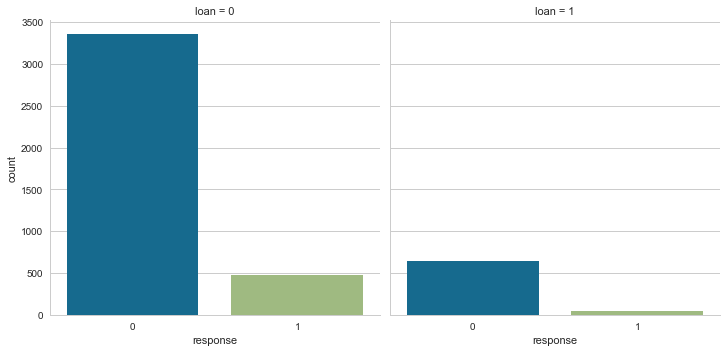

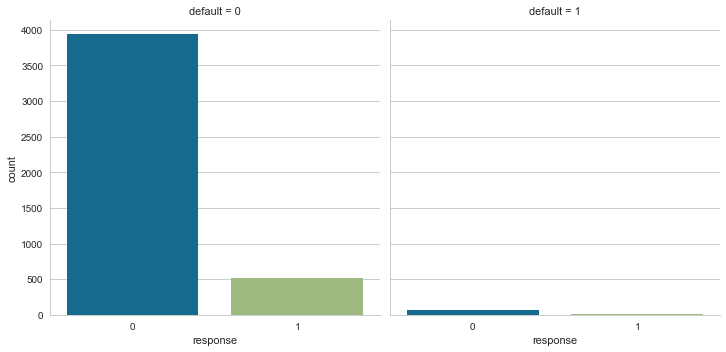

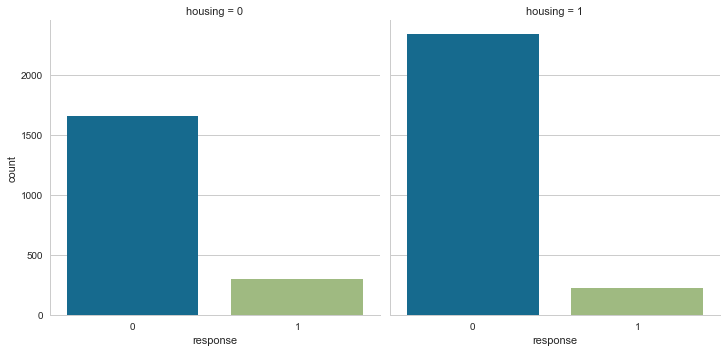

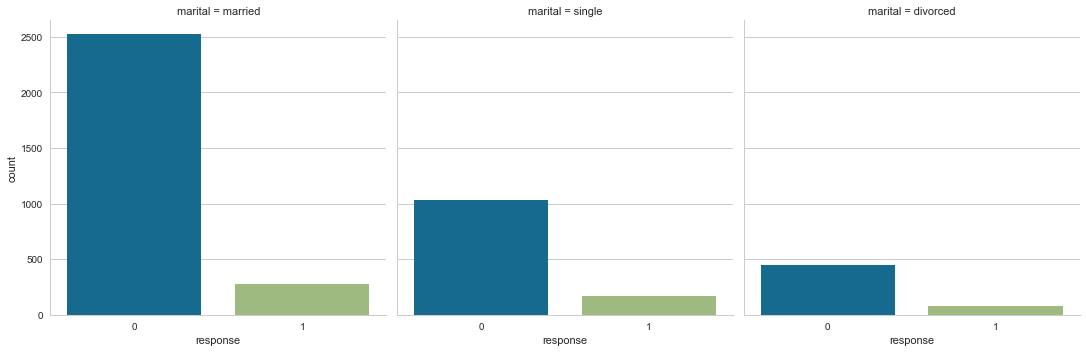

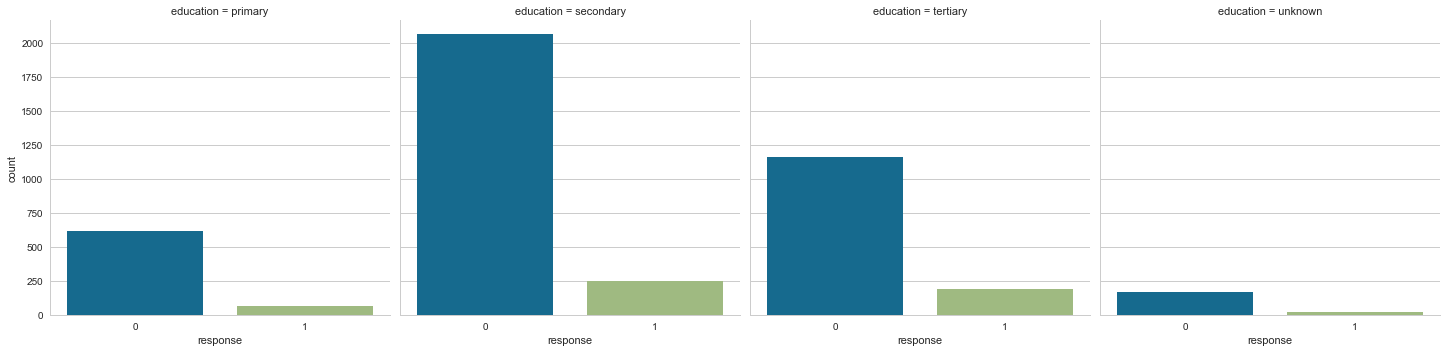

In [14]:
# Plot feature counts by response - loan
fig1 = sns.catplot(x="response", col="loan", data=bank1, kind="count")

# Plot feature counts by response - default
fig1 = sns.catplot(x="response", col="default", data=bank1, kind="count")

# Plot feature counts by response - housing
fig1 = sns.catplot(x="response", col="housing", data=bank1, kind="count")

# Plot feature counts by response - marital
fig1 = sns.catplot(x="response", col="marital", data=bank1, kind="count")

# Plot feature counts by response - education
fig1 = sns.catplot(x="response", col="education", data=bank1, kind="count")

**Figure 3: Balance Values by Predictor and Target Features**

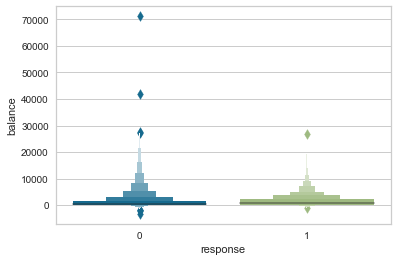

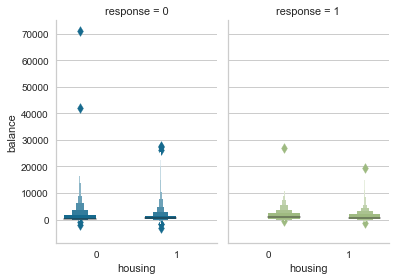

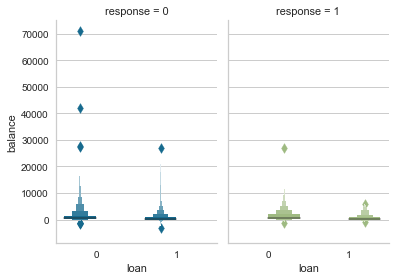

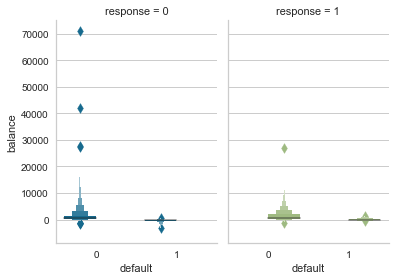

In [17]:
# Plot response values by balance
sns.boxenplot(x="response", y="balance", data=bank1, linewidth=2.5)

# Plot response values by balance and housing
g = sns.catplot(x="housing", y="balance", hue="response", col="response", data=bank1, 
                kind="boxen",height=4, aspect=.7);

# Plot response values by balance and loan
g = sns.catplot(x="loan", y="balance", hue="response", col="response", data=bank1, 
                kind="boxen",height=4, aspect=.7);

# Plot response values by balance and default
g = sns.catplot(x="default", y="balance", hue="response", col="response", data=bank1, 
                kind="boxen",height=4, aspect=.7);

**Figure 4: Age Values by Predictor and Target Features**

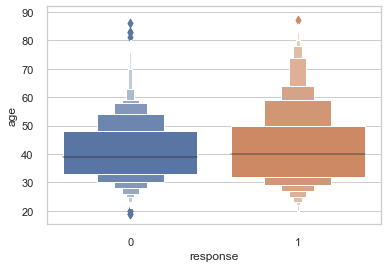

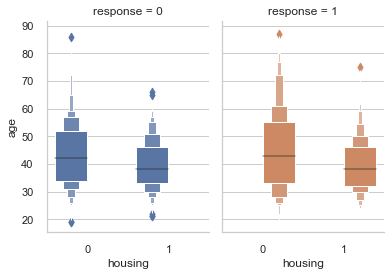

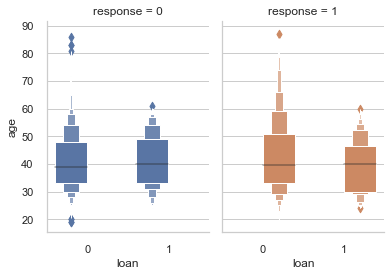

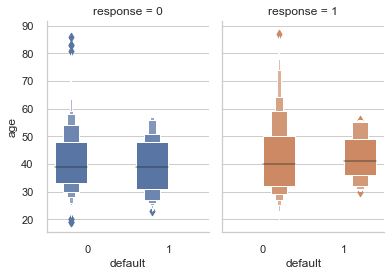

In [25]:
# Plot response values by balance
sns.boxenplot(x="response", y="age", data=bank1, linewidth=2.5)

# Plot response values by balance and housing
g = sns.catplot(x="housing", y="age", hue="response", col="response", data=bank1, 
                kind="boxen",height=4, aspect=.7);

# Plot response values by balance and loan
g = sns.catplot(x="loan", y="age", hue="response", col="response", data=bank1, 
                kind="boxen",height=4, aspect=.7);

# Plot response values by balance and default
g = sns.catplot(x="default", y="age", hue="response", col="response", data=bank1, 
                kind="boxen",height=4, aspect=.7);

**Figure 5: Balance Values by Target and Non-Predictor Features**

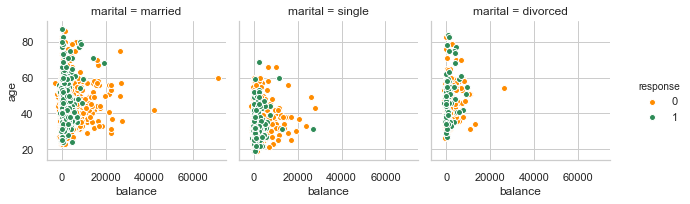

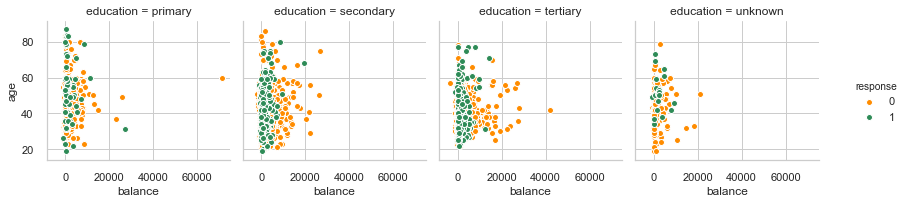

In [22]:
# Plot Balance by Marital Status, Age, and Response
sns.set(style="whitegrid")
g = sns.FacetGrid(bank1, hue="response", col="marital", margin_titles=True,
                  palette={1:"seagreen", 0:"darkorange"})
g = g.map(plt.scatter, "balance", "age",edgecolor="w").add_legend();

# Plot Balance by Education, Age, and Response
g = sns.FacetGrid(bank1, hue="response", col="education", margin_titles=True,
                  palette={1:"seagreen", 0:"darkorange"})
g = g.map(plt.scatter, "balance", "age",edgecolor="w").add_legend();

**Figure 6: Age by Education**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


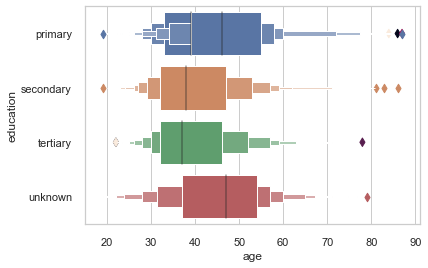

In [24]:
# Plot response values by balance and loan
ax = sns.boxenplot(x=bank1["age"])

# Median age by education
sns.boxenplot(x="age", y="education", data=bank1, linewidth=2.5)

**Figure 7: Feature Pair Plots**

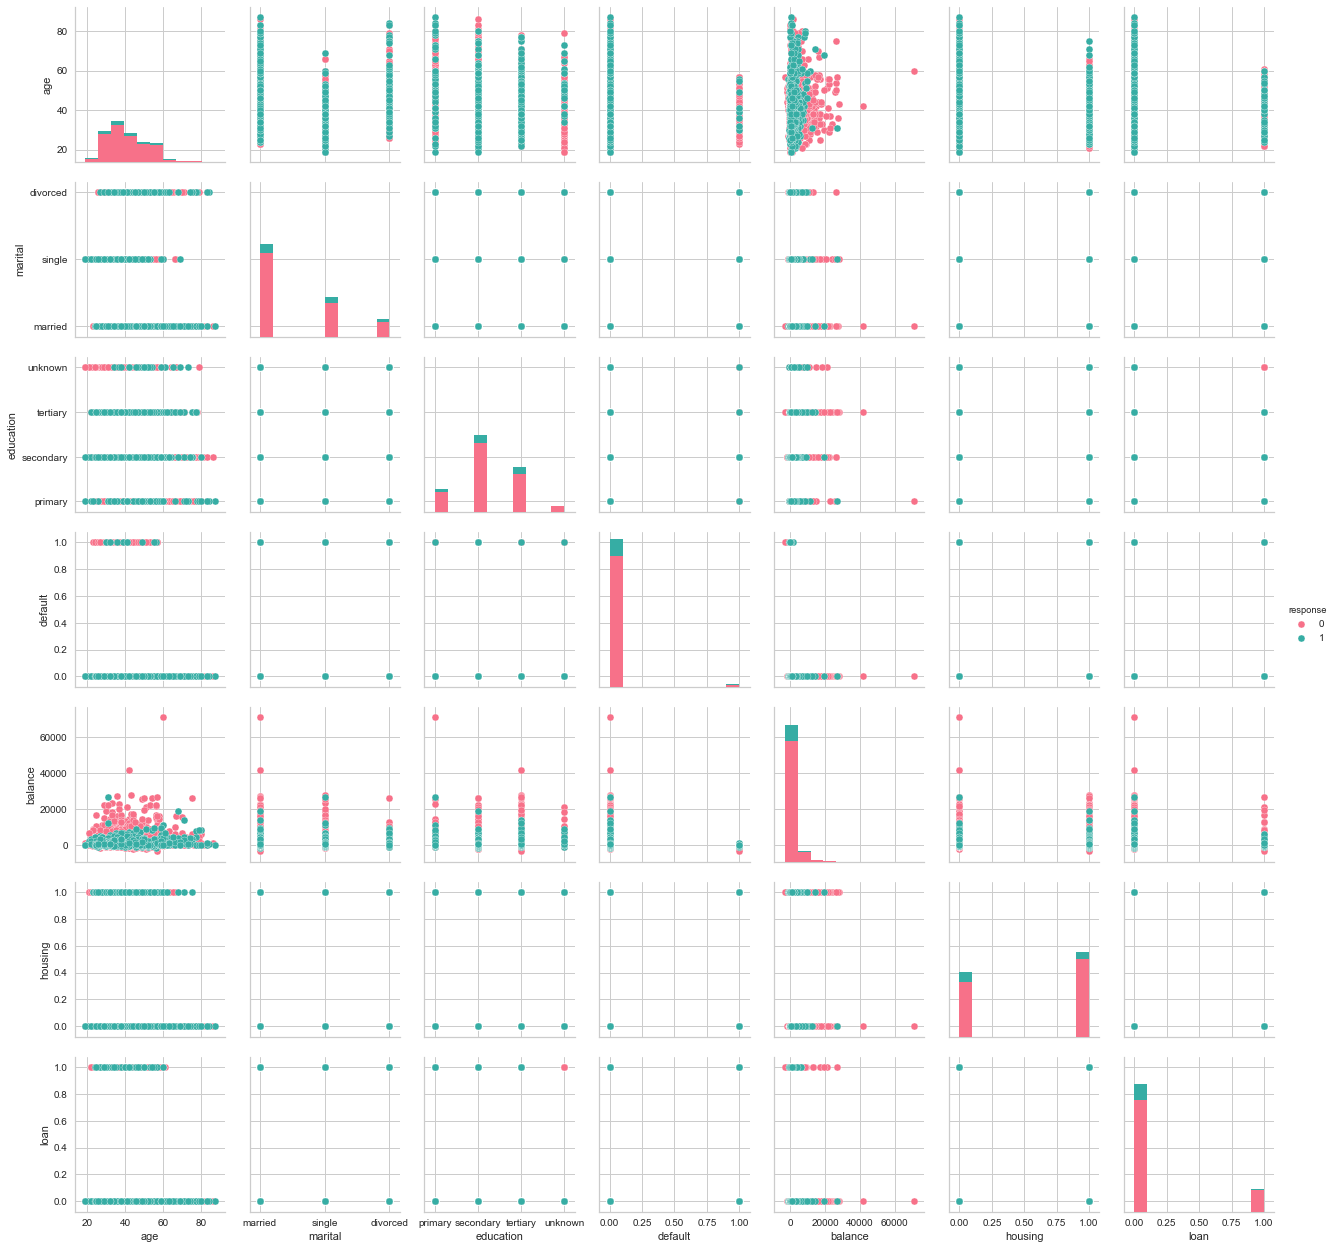

In [71]:
# Pair plots of selected features color-coded by response values
g = sns.pairplot(bank1, vars=["age", "marital", "education", "default", "balance", "housing", "loan"], 
                 hue="response", palette="husl")

**Figure 8: Correlation Matrix**

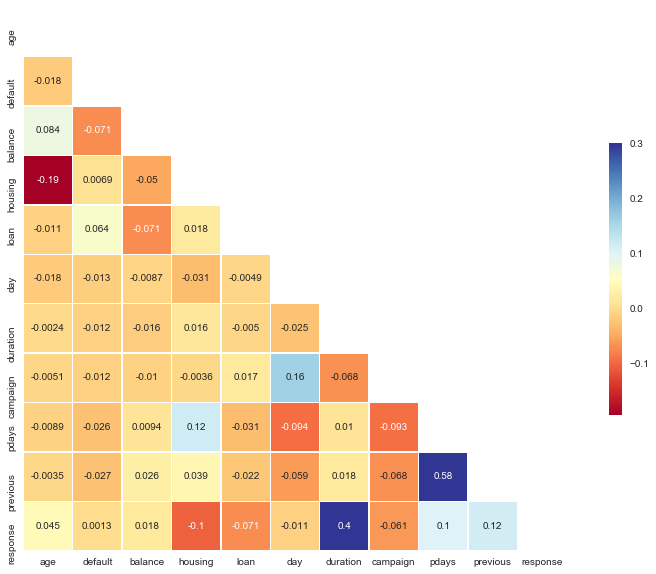

In [68]:
# Correlation matrix of all features
plt.figure(figsize=(15,10))
corr = bank1.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, vmax=.3, cmap="RdYlBu", square=True, linewidths = .5, 
            cbar_kws={"shrink": .5})

# Data split strategy 1 - stratified train test split

In [21]:
# Select subset of features
# Yes = 1, N0 = 0
bank_model_df = bank1.loc[:, ['default','housing','loan','response']]
bank_model_df.head()

,default,housing,loan,response
0,0,0,0,0
1,0,1,1,0
2,0,1,0,0
3,0,1,1,0
4,0,1,0,0


In [22]:
# Prepare data for train/test splitting
X = bank_model_df.iloc[:,0:3].values
y = bank_model_df.iloc[:,3].values

print('X shape: ', X.shape)
print('y shape: ', y.shape)

# Split into train and test sets and review
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

X shape:  (4521, 3)
y shape:  (4521,)
X_train.shape:  (3390, 3)
X_test.shape:  (1131, 3)
y_train.shape:  (3390,)
y_test.shape:  (1131,)


# Data split strategy 2 - upsampling
This intends to deal with the imbalance of Yes reponses (521) to No responses (4000) in the original data. 

In [61]:
# Training set
X = pd.DataFrame(bank[['loan_yes', 'default_yes', 'housing_yes', 'response_yes']])
trainnum = random.sample(range(1,4521), 521)
train = X.loc[trainnum]
test = X.drop(X.index[trainnum])

X_train = train[['loan_yes', 'default_yes', 'housing_yes']]
y_train = val.column_or_1d(train[['response_yes']])

# Display proportion of Response = yes samples
print(np.mean(X['response_yes']))

0.11523999115239991


In [62]:
# Test set
X_test = np.array(test[['loan_yes', 'default_yes', 'housing_yes']])
y_test = np.array(val.column_or_1d(test[['response_yes']]))

In [63]:
# Upsampling to address imbalance of "no" responses

# Separate majority and minority classes
minority = train[train['response_yes']==1]
majority = train[train['response_yes']==0]

# Upsample minority class and create new DataFrame
upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=123)
newbank = pd.concat([majority, upsampled])
newbank.response_yes.value_counts()

1    464
0    464
Name: response_yes, dtype: int64

In [64]:
newbank.head()
# len(newbank)

,loan_yes,default_yes,housing_yes,response_yes
4443,0,0,0,0
1305,1,0,1,0
1922,1,0,1,0
2167,0,0,0,0
1456,1,0,1,0


In [65]:
# Prepare upsampled data for train/test splitting
X = newbank.drop('response_yes', axis=1)
y = newbank.response_yes

print('X shape: ', X.shape)
print('y shape: ', y.shape)

# Split into train and test sets and review
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

X shape:  (928, 3)
y shape:  (928,)
X_train.shape:  (696, 3)
X_test.shape:  (232, 3)
y_train.shape:  (696,)
y_test.shape:  (232,)


# Learning phase 
Employ cross-validation design to test out accuracy for multiple classification models on training set

In [66]:
# Use Cross-validation
nfolds = 10

# Logistic Regression
log_reg = LogisticRegression(solver="lbfgs")
log_scores = cross_val_score(log_reg, X_train, y_train, cv=nfolds)
log_reg_mean = log_scores.mean()

# Naives Bayes - Gaussian
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=nfolds)
nav_mean = nav_scores.mean()

# Naive Bayes - Bernoulli
bern_clf = BernoulliNB()
bern_scores = cross_val_score(bern_clf, X_train, y_train, cv=nfolds)
bern_mean = bern_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=nfolds)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier(weights="distance")
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=nfolds)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=nfolds)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=nfolds)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=nfolds)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=nfolds)
neural_mean = neural_scores.mean()

# Stochastic Gradient Descent
sgd_clf = SGDClassifier(loss='log')
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=nfolds)
sgd_mean = sgd_scores.mean()

# Create a Dataframe with the results.
d = {'Classifiers': ['Logistic Reg.', 'Naives Bayes Gaussian', 'Naive Bayes Bernoulli', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'SGD'], 
    'Cross-validated Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean, bern_mean, sgd_mean]}

result_df = pd.DataFrame(data=d)

In [67]:
# Results DataFrame
result_df = result_df.sort_values(by=['Cross-validated Mean Scores'], ascending=False)
result_df

,Classifiers,Cross-validated Mean Scores
1,Naives Bayes Gaussian,0.642091
3,SVC,0.642091
4,KNN,0.642091
5,Dec Tree,0.642091
0,Logistic Reg.,0.620663
6,Grad B CLF,0.620663
8,Neural Classifier,0.620663
7,Rand FC,0.612050
2,Naive Bayes Bernoulli,0.555901
9,SGD,0.521781


**Figure 9: Cross-Validated F1 Scores for Logistic Regression and Naive Bayes Models**

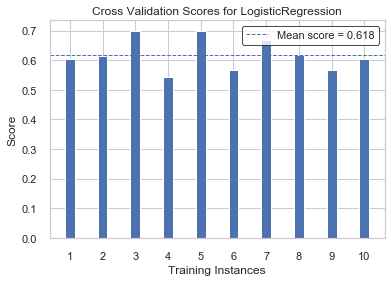

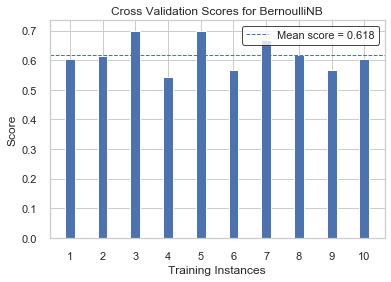

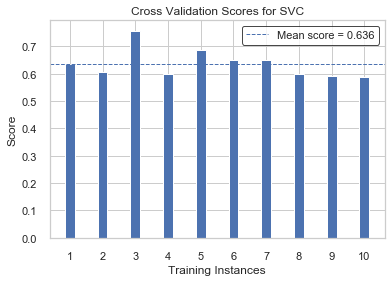

In [68]:
# Use YellowBrick Cross Val visualization for alternate evaluation

# Load the classification dataset
X, y = X_train, y_train

# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=10)

# Instantiate the classification model and visualizer - LR
model = LogisticRegression(solver="lbfgs")
visualizer = CVScores(model, cv=cv, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

# Instantiate the classification model and visualizer - NB
model = BernoulliNB()
visualizer = CVScores(model, cv=cv, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

# Instantiate the classification model and visualizer - SVC
model = SVC()
visualizer = CVScores(model, cv=cv, scoring='f1_weighted')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

**Figure 10: Scatterplot - Logistic Regression and Naive Bayes (Bernoulli) Models**

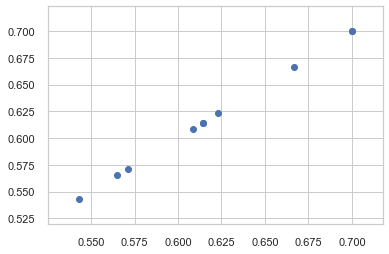

In [69]:
# Scatterplot of two models - LogReg and Naive Bayes (Bernoulli)
# Two models produce same results as training set size approaches infinity (?)
# NB assumption holds that xi's are conditionally independent of each other given y
plt.scatter(log_scores, bern_scores)

**Figure 11: Scatterplot - Logistic Regression and SVC Models**

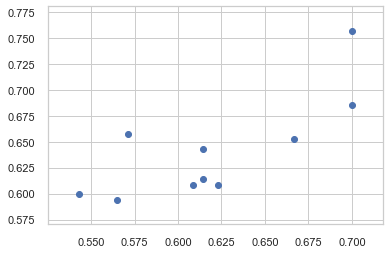

In [70]:
# Scatterplot of two models - LogReg and SVC
# Two models produce same results as training set size approaches infinity (?)
# NB assumption holds that xi's are conditionally independent of each other given y
plt.scatter(log_scores, svc_scores)

# Grid search to fine-tune models

In [17]:
# Grid Search to fine-tune short list of models
# Try different C and alpha values
# Try L1 versus L2

In [71]:
# Classifier parameters
lr_param = {'C': [0.001, 0.01, 0.1, 1, 5, 10]}
nb_param = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10]}
svc_param = {'C': [0.001, 0.01, 0.1, 1, 5, 10]}

print("Parameter grid:\n{}".format(lr_param))
print("Parameter grid:\n{}".format(nb_param))
print("Parameter grid:\n{}".format(svc_param))

# LR
gs_lr = GridSearchCV(LogisticRegression(), lr_param, cv=10, scoring="roc_auc", return_train_score=True)
gs_lr.fit(X_train, y_train)
print("Test set score: {:.2f}".format(gs_lr.score(X_test, y_test)))
print("Best parameters: {}".format(gs_lr.best_params_))
print("Best cross-validation score: {:.2f}".format(gs_lr.best_score_))
print("Best estimator:\n{}".format(gs_lr.best_estimator_))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 5, 10]}
Parameter grid:
{'alpha': [0.001, 0.01, 0.1, 1, 5, 10]}
Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 5, 10]}
Test set score: 0.61
Best parameters: {'C': 1}
Best cross-validation score: 0.62
Best estimator:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [51]:
# NB
gs_nb = GridSearchCV(BernoulliNB(binarize=0.5, class_prior = [0.5, 0.5], fit_prior=False), nb_param, cv=10, 
                    scoring="roc_auc", return_train_score=True)
gs_nb.fit(X_train, y_train)
print("Test set score: {:.2f}".format(gs_nb.score(X_test, y_test)))
print("Best parameters: {}".format(gs_nb.best_params_))
print("Best cross-validation score: {:.2f}".format(gs_nb.best_score_))
print("Best estimator:\n{}".format(gs_nb.best_estimator_))

Test set score: 0.66
Best parameters: {'alpha': 0.001}
Best cross-validation score: 0.63
Best estimator:
BernoulliNB(alpha=0.001, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)


In [73]:
# SVC
gs_svc = GridSearchCV(SVC(), svc_param, cv=10, scoring="roc_auc", return_train_score=True)
gs_svc.fit(X_train, y_train)
print("Test set score: {:.2f}".format(gs_svc.score(X_test, y_test)))
print("Best parameters: {}".format(gs_svc.best_params_))
print("Best cross-validation score: {:.2f}".format(gs_svc.best_score_))
print("Best estimator:\n{}".format(gs_svc.best_estimator_))

Test set score: 0.58
Best parameters: {'C': 5}
Best cross-validation score: 0.65
Best estimator:
SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [76]:
# Revise Logistic Regression and Naive Bayes parameters
log_reg = LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

bern_clf = BernoulliNB(alpha=0.001, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)

svc_clf = SVC(C=5, probability=True)

# Fit training set
- log_reg
- bern_clf
- svc_clf

In [77]:
# Fit Logistic Regression model
log_reg.fit(X_train, y_train)
lr_pred = log_reg.predict_proba(X_train)
lr_pred = [p[1] for p in lr_pred]
lr_pred_class = log_reg.predict(X_train)

In [78]:
# Fit Naive Bayes model
bern_clf.fit(X_train, y_train)
bern_pred = bern_clf.predict_proba(X_train)
bern_pred = [p[1] for p in bern_pred]
bern_pred_class = bern_clf.predict(X_train)

In [79]:
# Fit SVC model
svc_clf.fit(X_train, y_train)
svc_pred = svc_clf.predict_proba(X_train)
svc_pred = [p[1] for p in svc_pred]
svc_pred_class = svc_clf.predict(X_train)

In [107]:
# Define function for model performance metrics
def metrics(y, pred, predclass):
    print("Area Under the Curve: ", roc_auc_score(y, pred))
    myconfusion = confusion_matrix(y, predclass)
    PPV = (myconfusion[1,1]/(myconfusion[1,0]+myconfusion[1,1]))
    NPV = (myconfusion[0,0]/(myconfusion[0,0]+myconfusion[0,1]))
    print("\n Confusion Matrix: \n", myconfusion)
    print("\n PPV, Correctly Classifies Response Yes: \n", PPV)
    print("\n NPV, Correctly Classifies Response No: \n", NPV)
    
print("Logistic Regression: \n")
metrics(y_train, lr_pred, lr_pred_class)
print('-------------------')
print("Naive Bayes (Bernoulli): \n")
metrics(y_train, bern_pred, bern_pred_class)
print('-------------------')
print("SVC: \n")
metrics(y_train, svc_pred, svc_pred_class)
print('-------------------')

Logistic Regression: 

Area Under the Curve:  0.6244054696789537

 Confusion Matrix: 
 [[203 145]
 [119 229]]

 PPV, Correctly Classifies Response Yes: 
 0.6580459770114943

 NPV, Correctly Classifies Response No: 
 0.5833333333333334
-------------------
Naive Bayes (Bernoulli): 

Area Under the Curve:  0.6134974897608667

 Confusion Matrix: 
 [[203 145]
 [119 229]]

 PPV, Correctly Classifies Response Yes: 
 0.6580459770114943

 NPV, Correctly Classifies Response No: 
 0.5833333333333334
-------------------
SVC: 

Area Under the Curve:  0.6366015986259743

 Confusion Matrix: 
 [[190 158]
 [ 91 257]]

 PPV, Correctly Classifies Response Yes: 
 0.7385057471264368

 NPV, Correctly Classifies Response No: 
 0.5459770114942529
-------------------


In [82]:
# Precision recall curve - Logistic Regression
precision, recall, thresholds = precision_recall_curve(y_train, lr_pred)
print('Precision: ',precision)
print('------------------------')
print('Recall: ', recall)
print('------------------------')
print('Thresholds: ', thresholds)

Precision:  [0.50144092 0.60090703 0.60364465 0.61229947 0.60821918 0.33333333
 0.34782609 1.        ]
------------------------
Recall:  [1.         0.76149425 0.76149425 0.65804598 0.63793103 0.02298851
 0.02298851 0.        ]
------------------------
Thresholds:  [0.46056888 0.46080384 0.46124149 0.53336308 0.53380142 0.53403676
 0.53447502]


In [83]:
# Precision recall curve - Naive Bayes
precision, recall, thresholds = precision_recall_curve(y_train, bern_pred)
print('Precision: ',precision)
print('------------------------')
print('Recall: ', recall)
print('------------------------')
print('Thresholds: ', thresholds)

Precision:  [0.5        0.49602544 0.60904255 0.61229947 0.63142857 0.62756598
 1.        ]
------------------------
Recall:  [1.         0.89655172 0.65804598 0.65804598 0.63505747 0.61494253
 0.        ]
------------------------
Thresholds:  [0.35433557 0.37187963 0.37187963 0.59653044 0.61465051 0.61465051]


In [84]:
# Precision recall curve - SVC
precision, recall, thresholds = precision_recall_curve(y_train, svc_pred)
print('Precision: ',precision)
print('------------------------')
print('Recall: ', recall)
print('------------------------')
print('Thresholds: ', thresholds)

Precision:  [0.5        0.59819413 0.59954751 0.61336516 0.61630695 0.61927711
 0.58108108 0.77777778 1.        ]
------------------------
Recall:  [1.         0.76149425 0.76149425 0.73850575 0.73850575 0.73850575
 0.12356322 0.02011494 0.        ]
------------------------
Thresholds:  [0.34273207 0.34273207 0.34275808 0.34279046 0.34280553 0.61694899
 0.61704054 0.61706307]


**Figure 12: Logistic Regression Precision-Recall Curve**

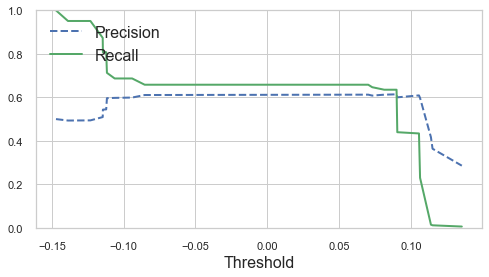

In [85]:
# Logistic Regression Precision Recall

# To decide on a threshold, look at decision scores
y_scores = cross_val_predict(log_reg, X_train, y_train, cv=3, method="decision_function")

# Compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

# Plot ROC
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.xlim([-400000, 400000])
# save_fig("precision_recall_vs_threshold_plot")
plt.show()

**Figure 13: Logistic Regression Precision-Recall Plot**

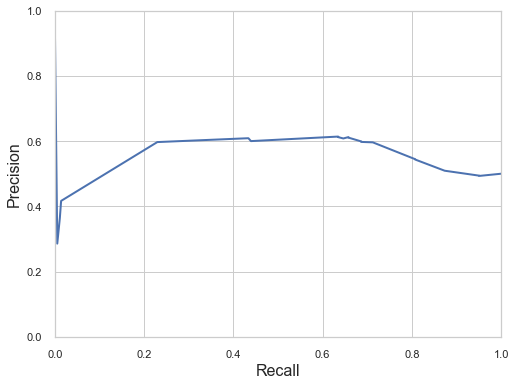

In [86]:
# Plot precision directly against recall for Logistic Regression

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# save_fig("precision_vs_recall_plot")
plt.show()

**Figure 14: Logistic Regression ROC Curve - Train Set**

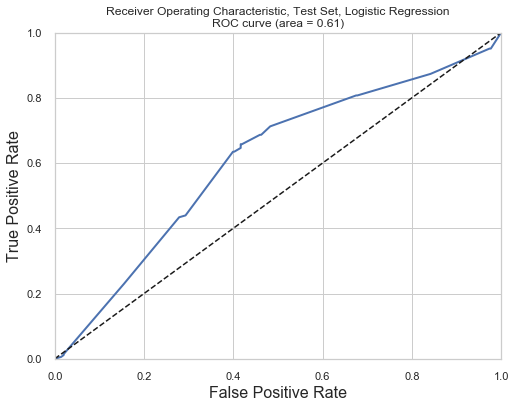

In [87]:
# ROC curve for Logistic Regression

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)
y_scores = cross_val_predict(log_reg, X_train, y_train, cv=10)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic, Test Set, Logistic Regression\nROC curve (area = %0.2f)' % roc_auc)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
plt.show()

**Figure 15: Naive Bayes (Bernoulli) ROC Curve - Train Set**

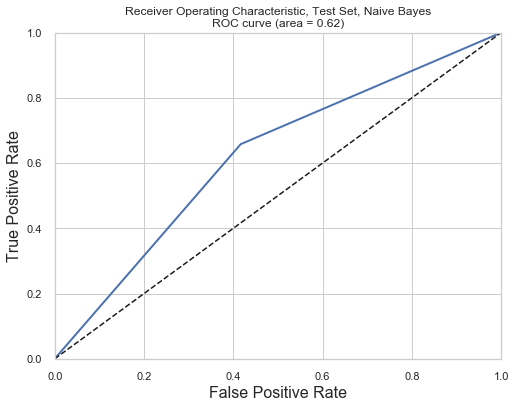

In [88]:
# ROC curve for Naive Bayes
y_scores = cross_val_predict(bern_clf, X_train, y_train, cv=10)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic, Test Set, Naive Bayes\nROC curve (area = %0.2f)' % roc_auc)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
plt.show()

**Figure 16: SVC ROC Curve - Train Set**

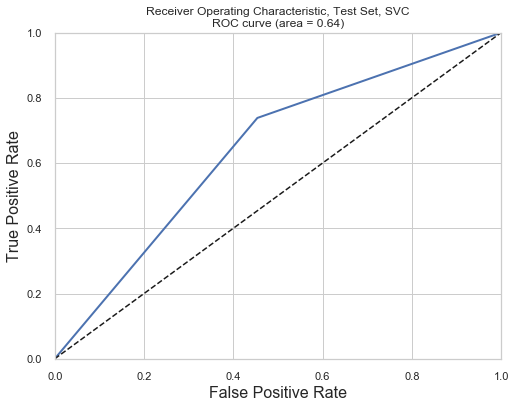

In [90]:
# ROC curve for SVC
y_scores = cross_val_predict(svc_clf, X_train, y_train, cv=10)
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic, Test Set, SVC\nROC curve (area = %0.2f)' % roc_auc)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
plt.show()

# Evaluate models on test set

In [91]:
# Logistic Regression
lr_pred_test = log_reg.predict_proba(X_test)
lr_pred_test = [p[1] for p in lr_pred_test]
lr_pred_class_test = log_reg.predict(X_test)

In [92]:
# Naive Bayes
bern_pred_test = bern_clf.predict_proba(X_test)
bern_pred_test = [p[1] for p in bern_pred_test]
bern_pred_class_test = bern_clf.predict(X_test)

In [93]:
# SVC
svc_pred_test = svc_clf.predict_proba(X_test)
svc_pred_test = [p[1] for p in svc_pred_test]
svc_pred_class_test = svc_clf.predict(X_test)

In [94]:
# Evaluate
print("Logistic Regression: \n")
metrics(y_test, lr_pred_test, lr_pred_class_test)
print('-------------------')
print("Naive Bayes (Bernoulli): \n")
metrics(y_test, bern_pred_test, bern_pred_class_test)
print('-------------------')
print("SVC: \n")
metrics(y_test, svc_pred_test, svc_pred_class_test)

Logistic Regression: 

Area Under the Curve:  0.6097651605231867

 Confusion Matrix: 
 [[72 44]
 [47 69]]

 PPV, Correctly Classifies Response Yes: 
 0.5948275862068966

 NPV, Correctly Classifies Response No: 
 0.6206896551724138
-------------------
Naive Bayes (Bernoulli): 

Area Under the Curve:  0.6064209274673009

 Confusion Matrix: 
 [[72 44]
 [47 69]]

 PPV, Correctly Classifies Response Yes: 
 0.5948275862068966

 NPV, Correctly Classifies Response No: 
 0.6206896551724138
-------------------
SVC: 

Area Under the Curve:  0.5816736028537455

 Confusion Matrix: 
 [[66 50]
 [44 72]]

 PPV, Correctly Classifies Response Yes: 
 0.6206896551724138

 NPV, Correctly Classifies Response No: 
 0.5689655172413793


In [ ]:
# Model is a little better than random

**Figure 17: Logistic Regression ROC Curve - Test Set**

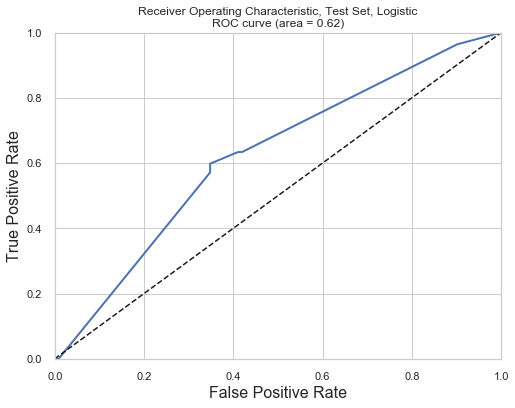

In [50]:
# ROC curve for Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_test)
roc_auc = auc(fpr, tpr)

# Plot curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic, Test Set, Logistic\nROC curve (area = %0.2f)' % roc_auc)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
plt.show()

**Figure 18: Naive Bayes (Bernoulli) ROC Curve - Test Set**

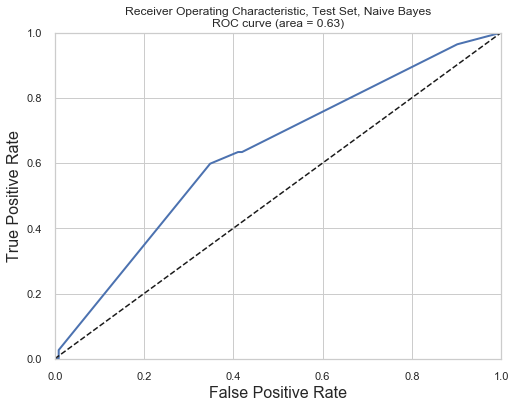

In [51]:
# ROC curve for Naive Bayes
fpr, tpr, thresholds = roc_curve(y_test, bern_pred_test)
roc_auc = auc(fpr, tpr)

# Plot curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic, Test Set, Naive Bayes\nROC curve (area = %0.2f)' % roc_auc)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
plt.show()

**Figure 19: SVC ROC Curve - Test Set**

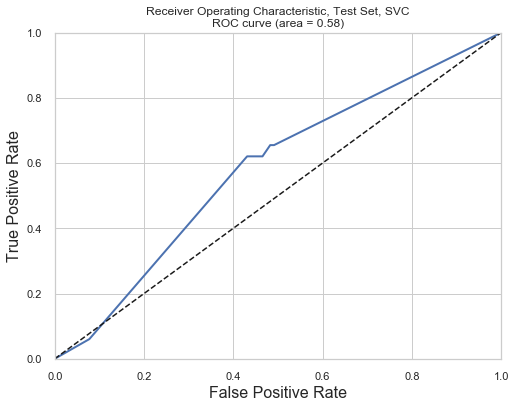

In [95]:
# ROC curve for SVC
fpr, tpr, thresholds = roc_curve(y_test, svc_pred_test)
roc_auc = auc(fpr, tpr)

# Plot curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic, Test Set, SVC\nROC curve (area = %0.2f)' % roc_auc)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# save_fig("roc_curve_plot")
plt.show()